# Conceitos básicos de Machine Learning - parte 3
Avaliando uma plataforma de anúncios de trabalho. Tomando por base o tempo esperado para se realizar um trabalho e o valor oferecido como pagamento, será que algum prestador de serviço aceitará a proposta?
## Importando os dados

In [209]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv"
dados = pd.read_csv(uri)
dados.head()

,unfinished,expected_hours,price
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


In [210]:
a_renomear = {
    'expected_hours' : 'horas_esperadas',
    'price' : 'preco',
    'unfinished' : 'nao_finalizado'
}
dados = dados.rename(columns = a_renomear)
dados.head()

,nao_finalizado,horas_esperadas,preco
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


In [211]:
troca = {
    0 : 1,
    1 : 0
}
dados['finalizado'] = dados.nao_finalizado.map(troca)
dados.head()

,nao_finalizado,horas_esperadas,preco,finalizado
0,1,26,192,0
1,1,88,9015,0
2,1,89,2577,0
3,1,42,275,0
4,1,39,170,0


In [212]:
dados.tail()

,nao_finalizado,horas_esperadas,preco,finalizado
2152,0,80,7518,1
2153,1,52,1332,0
2154,0,40,473,1
2155,0,75,5324,1
2156,1,37,377,0


## Visualizando os dados

<Axes: xlabel='horas_esperadas', ylabel='preco'>

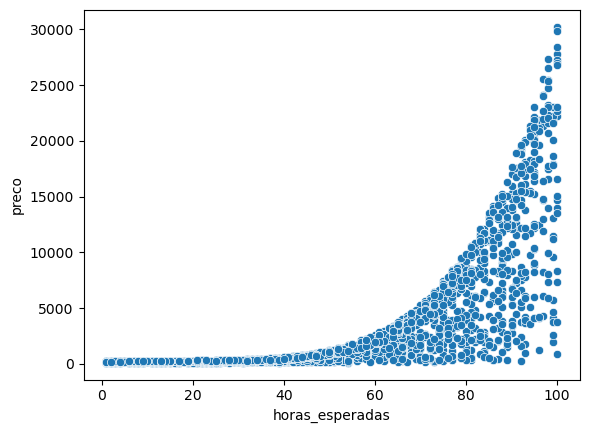

In [213]:
import seaborn as sns

sns.scatterplot(x="horas_esperadas", y="preco", data=dados)

<Axes: xlabel='horas_esperadas', ylabel='preco'>

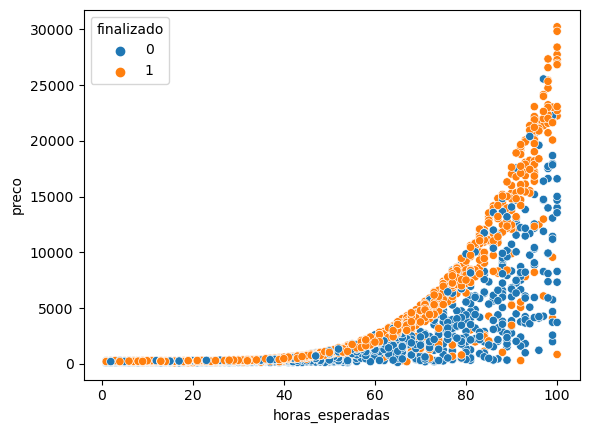

In [214]:
import seaborn as sns

sns.scatterplot(x="horas_esperadas", y="preco", hue='finalizado', data=dados)

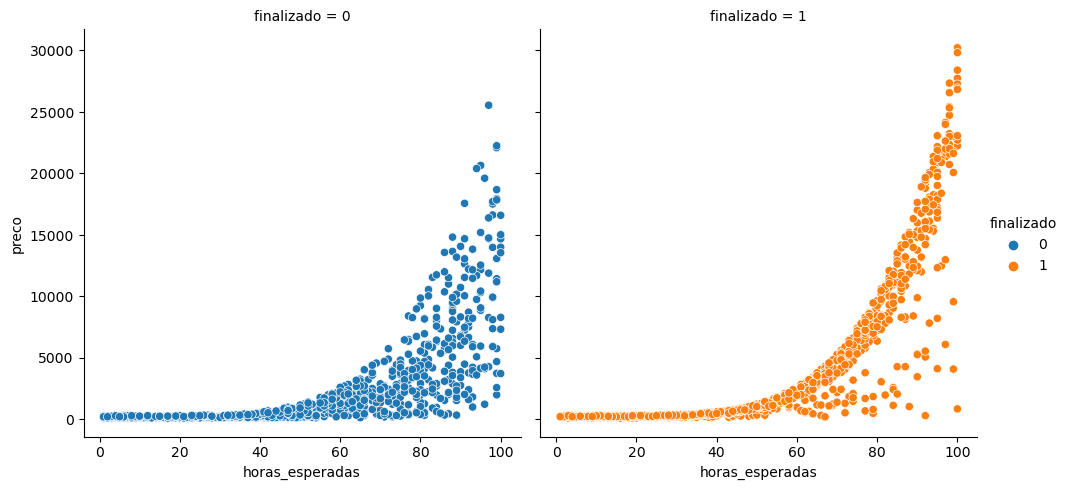

In [215]:
import seaborn as sns

sns.relplot(x="horas_esperadas", y="preco", hue='finalizado', col='finalizado', data=dados)

## Definindo, treinando e testando o modelo

In [216]:
x = dados[['horas_esperadas', 'preco']]
y = dados['finalizado']

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np

SEED = 20
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = LinearSVC(random_state=SEED)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acurácia foi 47.41%


D:\Users\guifr\anaconda3\envs\estudo\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\Users\guifr\anaconda3\envs\estudo\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Será que a acurácia acima foi boa? E se chutarmos todas as tarefas como finalizadas, será que teríamos uma boa estimativa?

In [218]:
previsoes_de_base = np.ones(540)
acuracia = accuracy_score(teste_y, previsoes_de_base) * 100
print("A acurácia do algoritmo de previsões de baseline foi %.2f%%" % acuracia)

A acurácia do algoritmo de previsões de baseline foi 52.59%


A estimativa foi melhor que a do nosso modelo o que indica que o modelo está muito ruim.

<Axes: xlabel='horas_esperadas', ylabel='preco'>

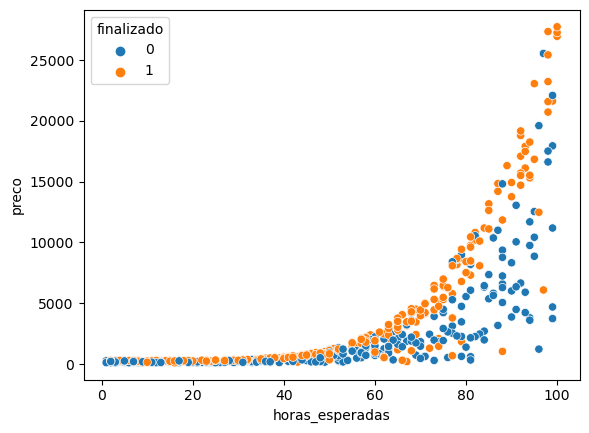

In [219]:
sns.scatterplot(x="horas_esperadas", y="preco", hue=teste_y, data=teste_x)

### Vamos analisar visualmente como nosso modelo esta classificando cada par ordenado do grafico, que representa cada possível instancia do dataset.

In [220]:
# Retorna todos os pares ordenados dentro do escopo do dataset
def retorna_pontos(x, y, pixels = 100):
    x_min, x_max, y_min, y_max = (x.min(), x.max(), y.min(), y.max())
    
    eixo_x_min, eixo_x_max = (x_min-0.05*(x_max-x_min), x_max+0.05*(x_max-x_min))
    passo_x = (x_max - x_min)/ pixels
    eixo_y_min, eixo_y_max = (y_min-0.05*(y_max-y_min), y_max+0.05*(y_max-y_min))
    passo_y = (y_max - y_min)/ pixels
    
    eixo_x = np.arange(eixo_x_min, eixo_x_max, passo_x)
    eixo_y = np.arange(eixo_y_min, eixo_y_max, passo_y)

    xx, yy = np.meshgrid(eixo_x, eixo_y)
    pontos = np.c_[xx.ravel(), yy.ravel()]

    return pontos, xx, yy

In [221]:
pontos, xx, yy = retorna_pontos(teste_x.horas_esperadas, teste_x.preco)
pontos

array([[-3.950000e+00, -1.280850e+03],
       [-2.960000e+00, -1.280850e+03],
       [-1.970000e+00, -1.280850e+03],
       ...,
       [ 1.019800e+02,  2.884348e+04],
       [ 1.029700e+02,  2.884348e+04],
       [ 1.039600e+02,  2.884348e+04]])

## O modelo prevê um valor para cada duplo ordenado

In [222]:
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)
Z

D:\Users\guifr\anaconda3\envs\estudo\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)

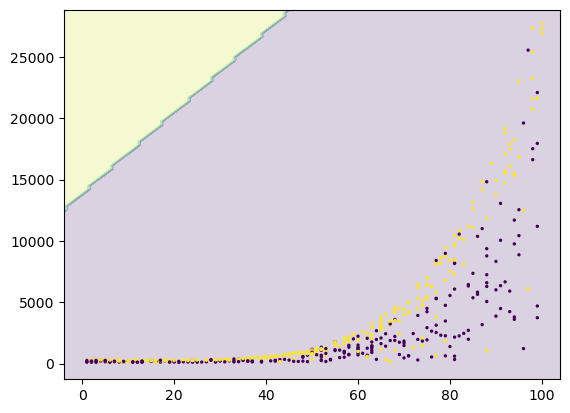

In [223]:
import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=2)

O gráfico acima mostra como o atual modelo classifica os dados. Como o modelo é um SVM (Support Vector Machine) linear, ele divide os dados de maneira linear, mas podemos ver que os dados estao sim separados mesmo que não totalmente, mas estão separados de forma não linear. Por isso, devemos optar por um modelo que possa se adaptar a essa não linearidade.
## Modelo não linear

In [224]:
from sklearn.svm import SVC

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = SVC(gamma='auto')
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acurácia foi 58.89%


In [225]:
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

D:\Users\guifr\anaconda3\envs\estudo\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


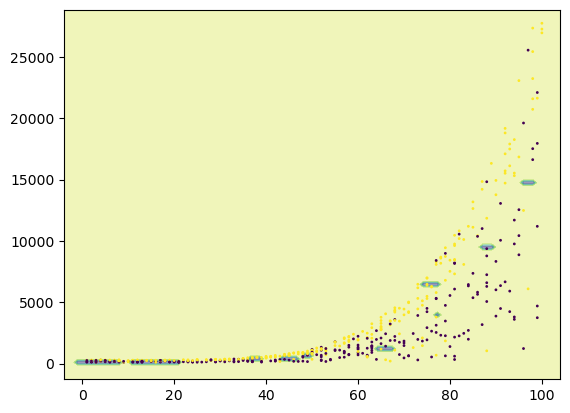

In [226]:
import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=1)

# DECISION BOUNDARY

Esse novo SVM embora seja não linear tem a desvatagem de ser sensível à escala e por isso antes de usá-lo devemos normalizar nossos dados.
## Normalizando os dados

In [227]:
from sklearn.preprocessing import StandardScaler

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

scaler = StandardScaler()
scaler.fit(treino_x)
raw_treino_x = scaler.transform(treino_x)
raw_teste_x = scaler.transform(teste_x)

modelo = SVC(gamma='auto')
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 1617 elementos e testaremos com 540 elementos
A acurácia foi 70.37%


In [228]:
pontos, xx, yy = retorna_pontos(raw_teste_x[:,0], raw_teste_x[:,1])

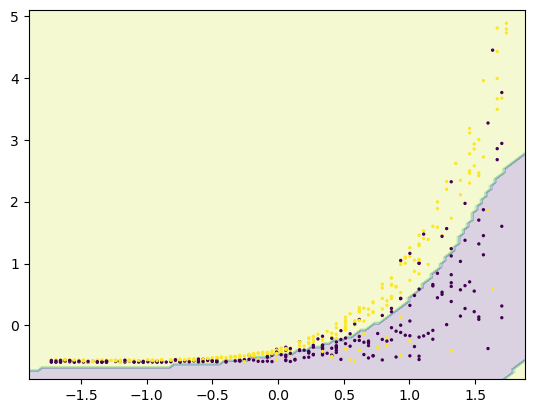

In [229]:
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(raw_teste_x[:,0], raw_teste_x[:,1], c=teste_y, s=2)

Acima, vemos que nosso novo modelo se adaptou bem aos dados. Ele ainda não tem uma acurácia de 100% mas eh capaz de perceber a tendência geral dos dados o que já é muito bom e a maioria de seus erros está mais numa zona fronteiriça das classificações e erros assim seriam esperados até de um ser humano.